In [1]:
# Import all necessary libraries in one cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb


In [3]:
# Load the dataset from the provided CSV file
file_path = '/content/diabetes (1).csv'
df = pd.read_csv(file_path)
# Display the first few rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 3. Exploratory Data Analysis (EDA)

In [5]:
# Check for missing values (0s in some columns are considered missing)
print('Missing values per column:')
print(df.isnull().sum())

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [6]:
# In this dataset, 0s in certain columns mean missing values (except for Pregnancies and Outcome)
cols_with_zero_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero_missing:
    print(f"{col} has {(df[col] == 0).sum()} zeros (treated as missing)")


Glucose has 5 zeros (treated as missing)
BloodPressure has 35 zeros (treated as missing)
SkinThickness has 227 zeros (treated as missing)
Insulin has 374 zeros (treated as missing)
BMI has 11 zeros (treated as missing)


<Figure size 1200x800 with 0 Axes>

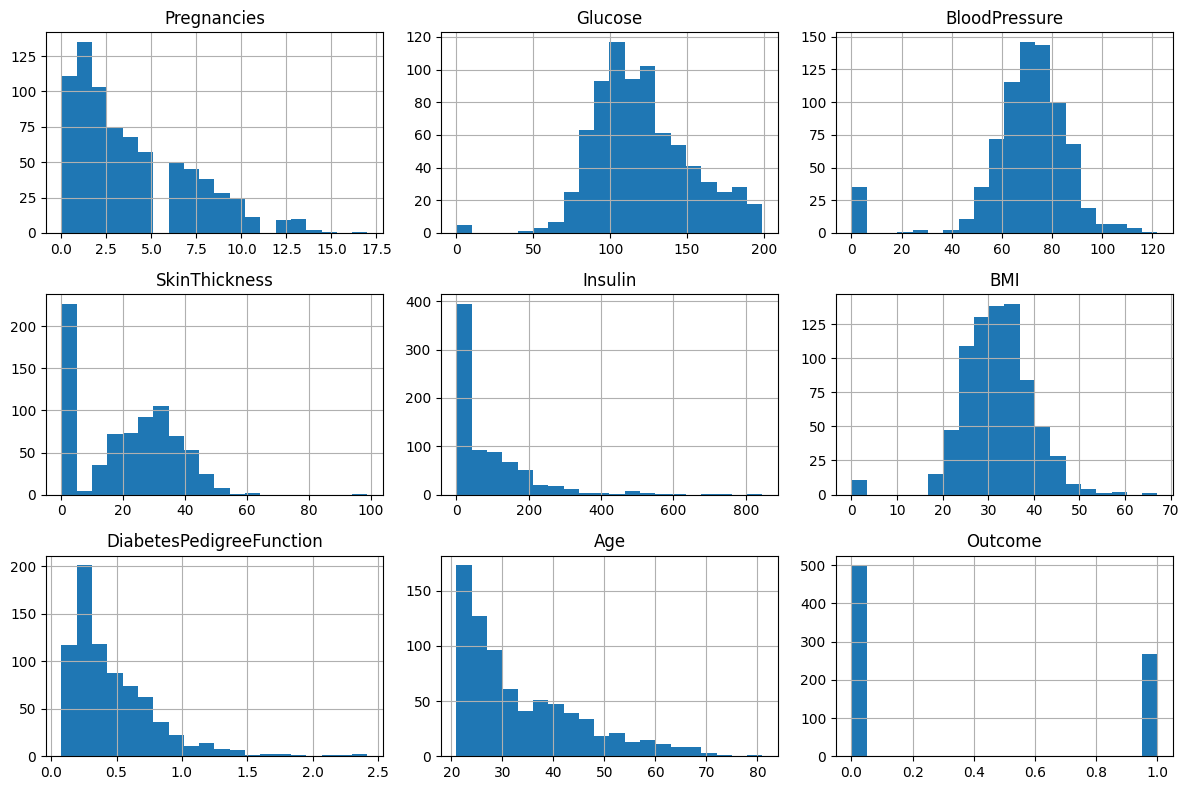

In [7]:
# Visualize distributions with histograms
plt.figure(figsize=(12,8))
df.hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

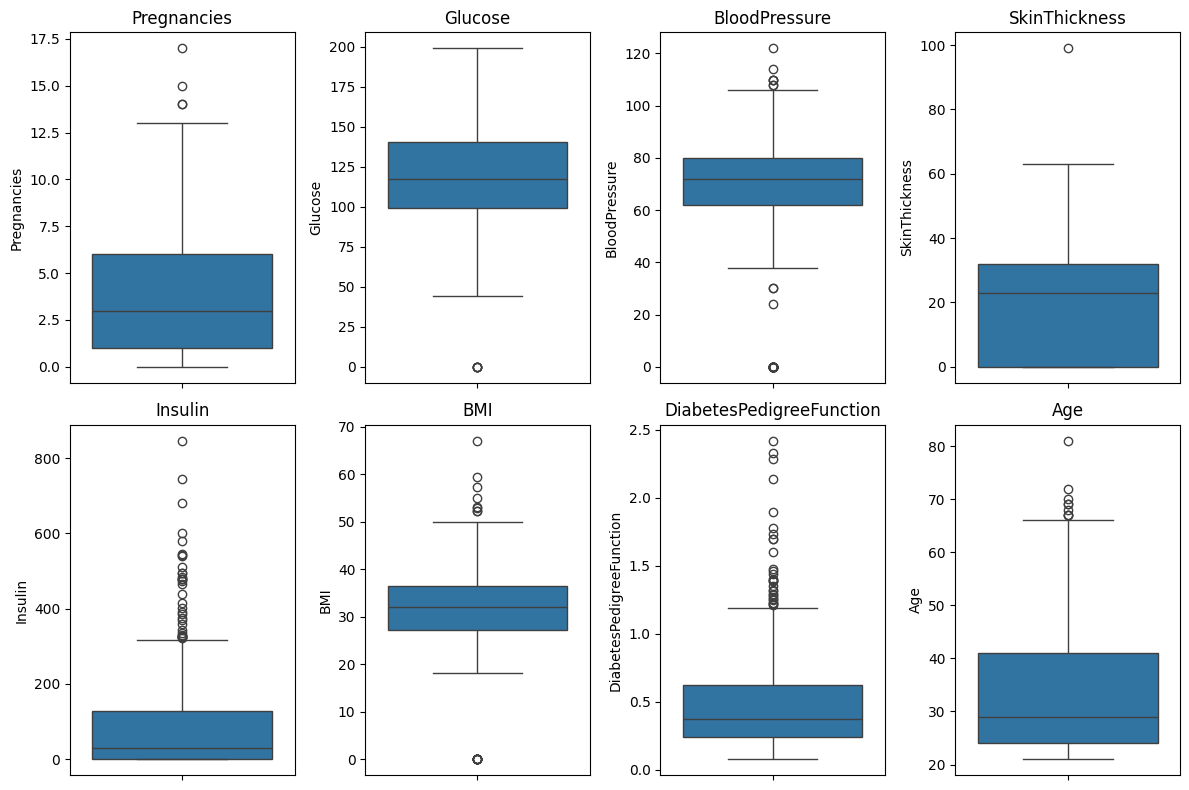

In [8]:
# Box plots for outlier detection
plt.figure(figsize=(12,8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2,4,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

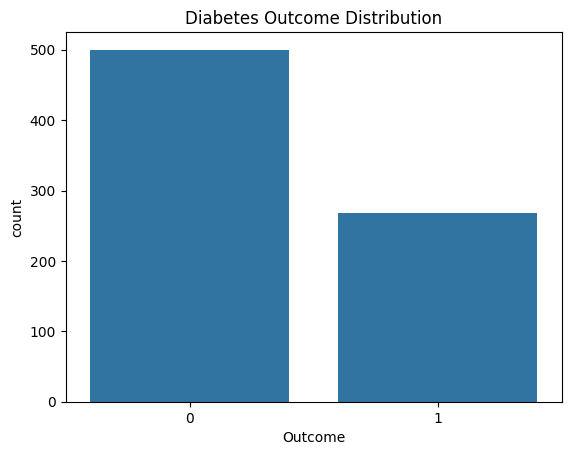

In [9]:
# Bar plot: Outcome counts
sns.countplot(x='Outcome', data=df)
plt.title('Diabetes Outcome Distribution')
plt.show()

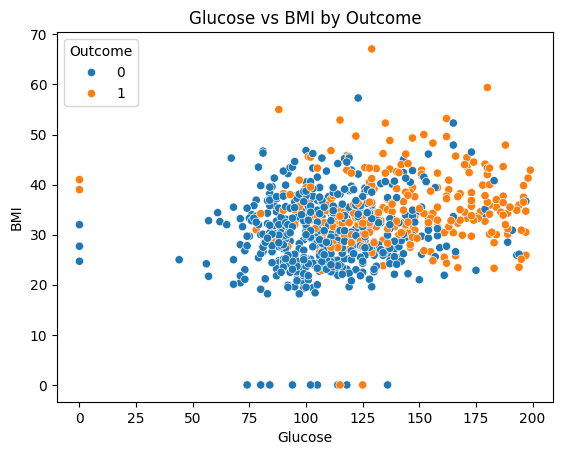

In [10]:
# Scatter plot: Glucose vs BMI colored by Outcome
sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', data=df)
plt.title('Glucose vs BMI by Outcome')
plt.show()


# 4. Data Preprocessing

In [13]:
# Replace zeros with NaN in relevant columns
for col in cols_with_zero_missing:
    df[col] = df[col].replace(0, np.nan)

# Impute missing values with median (robust to outliers)
imputer = SimpleImputer(strategy='median')
df[cols_with_zero_missing] = imputer.fit_transform(df[cols_with_zero_missing])

# Feature scaling (important for tree-based models, but not strictly required)
scaler = StandardScaler()
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 5. Split Data into Train and Test Sets

In [14]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


# 6. Build and Evaluate LightGBM and XGBoost Models

In [16]:
# Define evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int) if y_pred.ndim == 1 else y_pred
    print('Accuracy:', accuracy_score(y_test, y_pred_binary))
    print('Precision:', precision_score(y_test, y_pred_binary))
    print('Recall:', recall_score(y_test, y_pred_binary))
    print('F1 Score:', f1_score(y_test, y_pred_binary))
    print('\nClassification Report:\n', classification_report(y_test, y_pred_binary))
    return accuracy_score(y_test, y_pred_binary), precision_score(y_test, y_pred_binary), recall_score(y_test, y_pred_binary), f1_score(y_test, y_pred_binary)


In [17]:
# LightGBM
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
print('LightGBM Performance:')
lgbm_metrics = evaluate_model(lgbm, X_test, y_test)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [18]:
# XGBoost
xgbm = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgbm.fit(X_train, y_train)
print('XGBoost Performance:')
xgbm_metrics = evaluate_model(xgbm, X_test, y_test)

XGBoost Performance:
Accuracy: 0.7597402597402597
Precision: 0.673469387755102
Recall: 0.6111111111111112
F1 Score: 0.6407766990291263

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:37:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# 7. Cross-Validation and Hyperparameter Tuning

In [19]:
#Grid search for LightGBM (can do similar for XGBoost)
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}
grid_lgbm = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
print('Best LightGBM Params:', grid_lgbm.best_params_)
print('Best LightGBM F1 (CV):', grid_lgbm.best_score_)


[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [20]:
# Evaluate best model on test set
evaluate_model(grid_lgbm.best_estimator_, X_test, y_test)

Accuracy: 0.7662337662337663
Precision: 0.6875
Recall: 0.6111111111111112
F1 Score: 0.6470588235294118

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       100
           1       0.69      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



(0.7662337662337663, 0.6875, 0.6111111111111112, 0.6470588235294118)

# 8. Comparative Analysis and Visualization

      Model  Accuracy  Precision    Recall  F1 Score
0  LightGBM  0.727273   0.620000  0.574074  0.596154
1   XGBoost  0.759740   0.673469  0.611111  0.640777


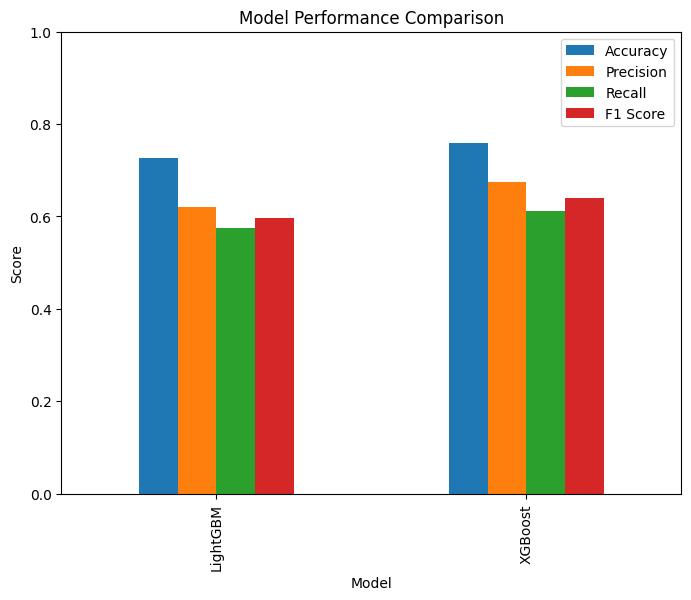

In [21]:
# Compare metrics
metrics_df = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'Accuracy': [lgbm_metrics[0], xgbm_metrics[0]],
    'Precision': [lgbm_metrics[1], xgbm_metrics[1]],
    'Recall': [lgbm_metrics[2], xgbm_metrics[2]],
    'F1 Score': [lgbm_metrics[3], xgbm_metrics[3]]
})
print(metrics_df)

# Bar plot for comparison
metrics_df.set_index('Model').plot(kind='bar', figsize=(8,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()


# Summary
: All necessary Python libraries for data handling, visualization, preprocessing, and modeling were imported in a single cell for clarity and reproducibility.

Data Loading: The dataset was loaded using pandas, and the first few rows were displayed to understand its structure.

Exploratory Data Analysis (EDA):

Checked for missing values and identified columns where zeros should be treated as missing.

Visualized data distributions using histograms and box plots to detect outliers and understand feature ranges.

Used bar plots and scatter plots to explore relationships between features and the target variable.

Data Preprocessing:

Replaced zeros with NaN in relevant columns and imputed missing values using the median.

Scaled features using standardization to ensure fair comparison between models.

Train-Test Split: The data was split into training and testing sets to evaluate model generalization.

Model Building and Evaluation:

Built and trained LightGBM and XGBoost classifiers on the training data.

Evaluated both models on the test set using accuracy, precision, recall, and F1-score.

Optionally, cross-validation and hyperparameter tuning were performed to optimize model performance.

Comparative Analysis:

Compared the performance metrics of both models in a table and visualized the results with bar plots.

Interpreted the strengths and weaknesses of each algorithm based on the results.